<a href="https://colab.research.google.com/github/ruanvirginio/scriptsMestrado/blob/main/transformaBaseST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando os dados

In [7]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

warnings.filterwarnings("ignore")

url = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/Medicoes_2018-2024.csv"

df = pd.read_csv(url,  sep=',', encoding='latin-1', skiprows=1)

df['Potência Ativa'] = pd.to_numeric(df['Potência Ativa'].str.replace(',', '.'), errors='coerce')
df['Potência Reativa'] = pd.to_numeric(df['Potência Reativa'].str.replace(',', '.'), errors='coerce')

# df.tail(3)


In [8]:
# df['Equipamento Medição'].unique()

In [9]:
# Filtrando pra um transformador específico
# df_ctr = df[df['TRAFO'] == 'CTR_DJ_12B1']

# Criar o boxplot para a potência ativa de CTR-02T1
# plt.figure(figsize=(10, 6))
# sns.boxplot(y='P', data=df_ctr)
# plt.title('Boxplot da Potência Ativa para o Transformador CTR-02T1')
# plt.ylabel('Potência Ativa')
# plt.show()

## Funções para tratar Outliers

In [10]:
# Função para aplicar o filtro IQR
def filtrar_coluna_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 3.2 * IQR

    return df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]

# Função para aplicar o filtro baseado em Média Móvel
def filtrar_coluna_media_movel(df, coluna, janela=20, threshold=4):

    media_movel = df[coluna].rolling(window=janela, center=True).mean()
    desvio = np.abs(df[coluna] - media_movel)

    limite_superior = media_movel + threshold * desvio.std()
    limite_inferior = media_movel - threshold * desvio.std()

    return df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

# Função para aplicar o filtro baseado em Z-Score
def filtrar_coluna_zscore(df, coluna, threshold=3):
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    z_scores = (df[coluna] - media) / desvio_padrao

    return df[np.abs(z_scores) < threshold]

# Função que aplica o filtro escolhido
def aplicar_filtro(df, coluna, metodo='iqr', janela=20, threshold=4, z_threshold=3):
    if metodo == 'iqr':
        return filtrar_coluna_iqr(df, coluna)
    elif metodo == 'media_movel':
        return filtrar_coluna_media_movel(df, coluna, janela=janela, threshold=threshold)
    elif metodo == 'zscore':
        return filtrar_coluna_zscore(df, coluna, threshold=z_threshold)
    else:
        raise ValueError("Método inválido! Escolha entre 'iqr', 'media_movel' ou 'zscore'.")


## Tratamento dos Dados

In [11]:
df.rename(columns={
    'Potência Ativa': 'P',
    'Potência Reativa': 'Q',
    'Data/Hora Medição': 'datahora',
    'Equipamento Medição': 'TRAFO'
}, inplace=True)

# Convertendo para datetime e salvando o módulo dos valores, pois pode ocorrer valores negativos
# df['datahora'] = pd.to_datetime(df['datahora'], dayfirst=True, errors='coerce')
df['datahora'] = pd.to_datetime(df['datahora'], format='%d/%m/%Y %H:%M:%S')

df['P'] = df['P'].abs()  # salvando o módulo dos valores
df['Q'] = df['Q'].abs()
df['S'] = np.sqrt(df['P']**2 + df['Q']**2)  # Calculando a potência aparente (S), em kVA

# Removendo linhas com S = 0
df = df[df['S'] != 0]

# DataFrame final para armazenar os dados filtrados
df_filtrado = pd.DataFrame()

# Escolha do método de filtragem ('iqr', 'media_movel' ou 'zscore')
metodo_filtro = 'iqr'

# Aplicando o filtro pra limpar os outliers pra cada transformador
for trafo in df['TRAFO'].unique():
    df_trafo = df[df['TRAFO'] == trafo]

    df_trafo_filtrado = aplicar_filtro(df_trafo, 'S', metodo=metodo_filtro, janela=20, threshold=4, z_threshold=3)

    # Adicionar os dados filtrados ao DataFrame final
    df_filtrado = pd.concat([df_filtrado, df_trafo_filtrado], ignore_index=True)

# Ordenando e removendo duplicatas
df_filtrado = df_filtrado.sort_values(by=['TRAFO', 'datahora'])
df_filtrado = df_filtrado.drop_duplicates(subset=['datahora', 'TRAFO'])

# Lista de transformadores para análise
trafos_escolhidos = [
    # LESTE
    'BSA_DJ_12B1', 'CAA_DJ_12B1', 'MAA_DJ_12B1',

    # CENTRO
    'ARA_DJ_12B1', 'BQR_DJ_12B1', 'RIC_DJ_12B1',

    # OESTE
    'CRM_DJ_12T1' , 'PBL_DJ_12B1', 'PTS_DJ_12B1'
]

# Criando gráfico da Potência Aparente ao longo do tempo, separada por TRAFO
# fig_aparente = px.line(df_filtrado, x='datahora', y='S', color='TRAFO',
#                        title='Potência Aparente ao Longo do Tempo por Transformador',
#                        labels={'S': 'Potência Aparente (kVA)', 'Dia': 'Data'})

# Exibir ou salvar o gráfico em
# fig_aparente.show()
# fig_aparente.write_html("Demanda ao longo do tempo - IQR.html")

## Experimentos

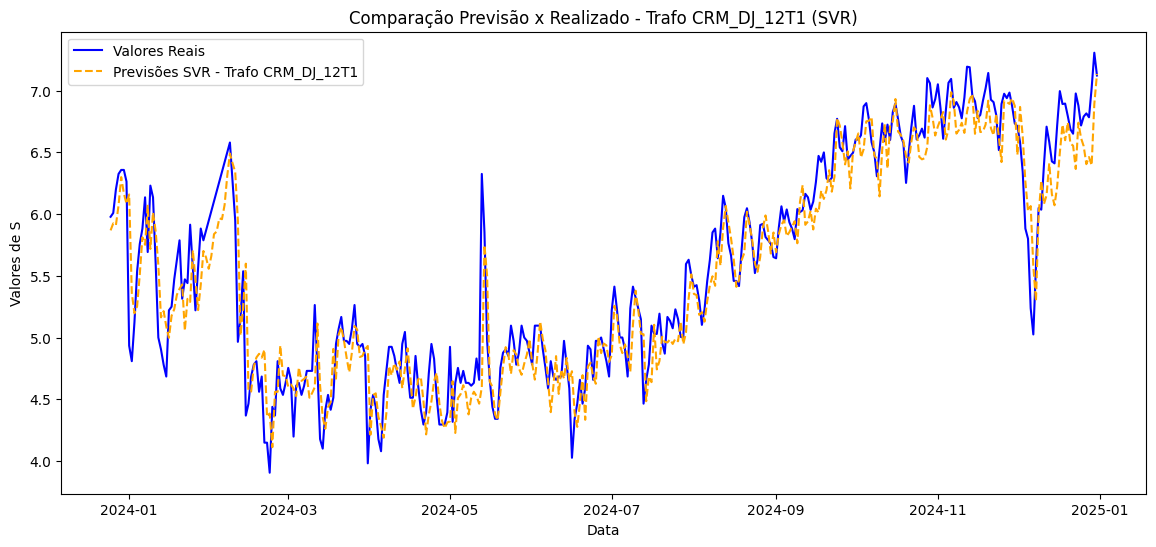

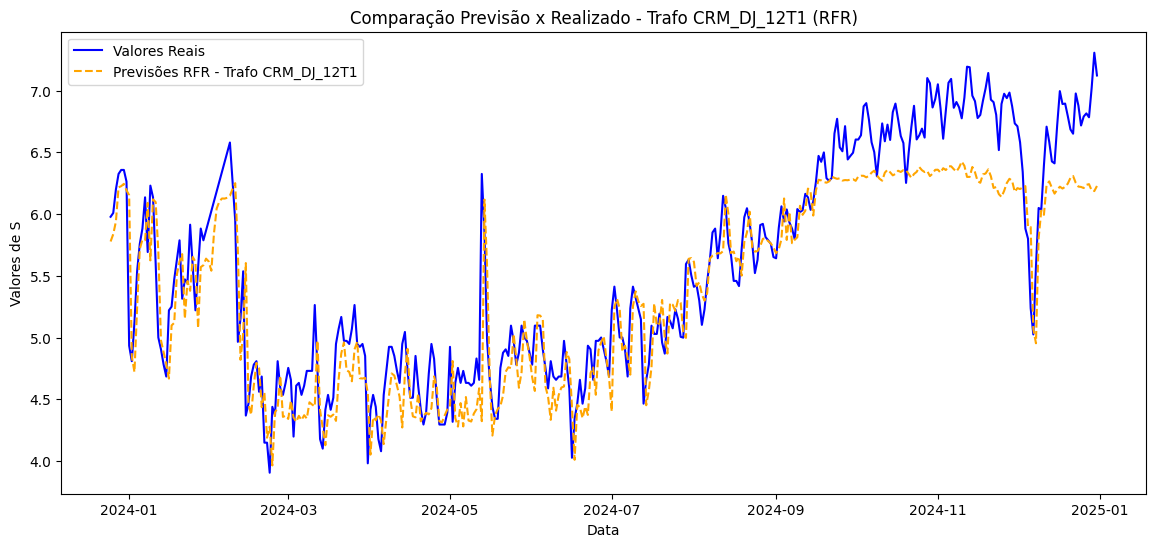

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


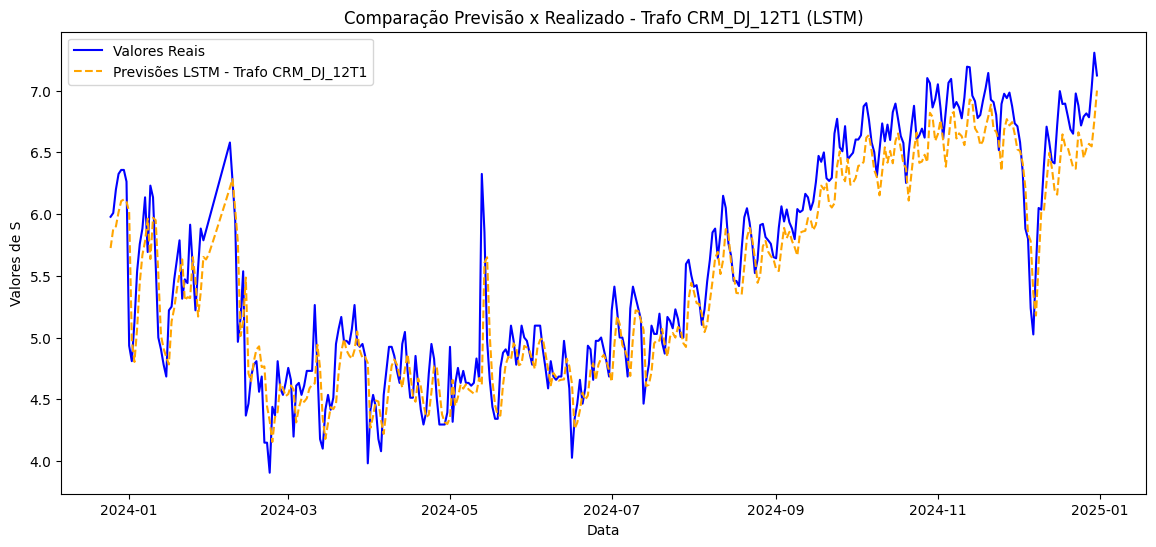

Resultados SVR:
         Trafo Modelo  RMSE  MAE   R2
0  CRM_DJ_12T1    SVR  0.29 0.21 0.89

Resultados RFR:
         Trafo Modelo  RMSE  MAE   R2
0  CRM_DJ_12T1    RFR  0.38 0.29 0.81

Resultados LSTM:
         Trafo Modelo  RMSE  MAE   R2
0  CRM_DJ_12T1   LSTM  0.30 0.23 0.89


In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import random

# Fixando seeds para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo):
    plt.figure(figsize=(14, 6))
    plt.plot(df_previsoes, y_test_inverso, label='Valores Reais', color='blue')
    plt.plot(df_previsoes, y_pred, label=f'Previsões {modelo} - Trafo {trafo}', linestyle='--', color='orange')
    plt.xlabel('Data')
    plt.ylabel('Valores de S')
    plt.title(f'Comparação Previsão x Realizado - Trafo {trafo} ({modelo})')
    plt.legend()
    plt.show()

def treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo, janela, epochs=20, batch_size=32):
    resultados = []

    for trafo in trafos_escolhidos:
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S']]
        df = df.set_index(['datahora']).resample('D').max()
        df.sort_index(inplace=True)
        df['S'] = df['S'].interpolate(method='linear')

        dados = df[['S']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler.fit_transform(dados)

        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, 0])
            y.append(dados_normalizados[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1)) if modelo == 'LSTM' else X

        split = int(len(X) * 0.83)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        if modelo == 'SVR':
            regressor = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=0.01)

        elif modelo == 'RFR':
            regressor = RandomForestRegressor(n_estimators=250, random_state=42)
        elif modelo == 'LSTM':
            regressor = Sequential()
            regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
            regressor.add(LSTM(units=50))
            regressor.add(Dense(1))
            regressor.compile(optimizer='adam', loss='mean_squared_error')
            regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        regressor.fit(X_train, y_train) if modelo != 'LSTM' else None
        y_pred_normalizado = regressor.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred_normalizado.reshape(-1, 1))
        y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

        mse = mean_squared_error(y_test_inverso, y_pred)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test_inverso, y_pred)
        r2 = r2_score(y_test_inverso, y_pred)

        df_previsoes = df.index[split + janela:]
        plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo)

        resultados.append({
            'Trafo': trafo,
            'Modelo': modelo,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

    return pd.DataFrame(resultados)

# Chamando para SVR, RFR e LSTM
resultados_svr = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='SVR', janela=365)
resultados_rfr = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='RFR', janela=365)
resultados_lstm = treinar_e_prever_modelo(df_filtrado, trafos_escolhidos, modelo='LSTM', janela=365, epochs=20, batch_size=32)

print("Resultados SVR:")
print(resultados_svr)
print("\nResultados RFR:")
print(resultados_rfr)
print("\nResultados LSTM:")
print(resultados_lstm)


## Cross-Validation

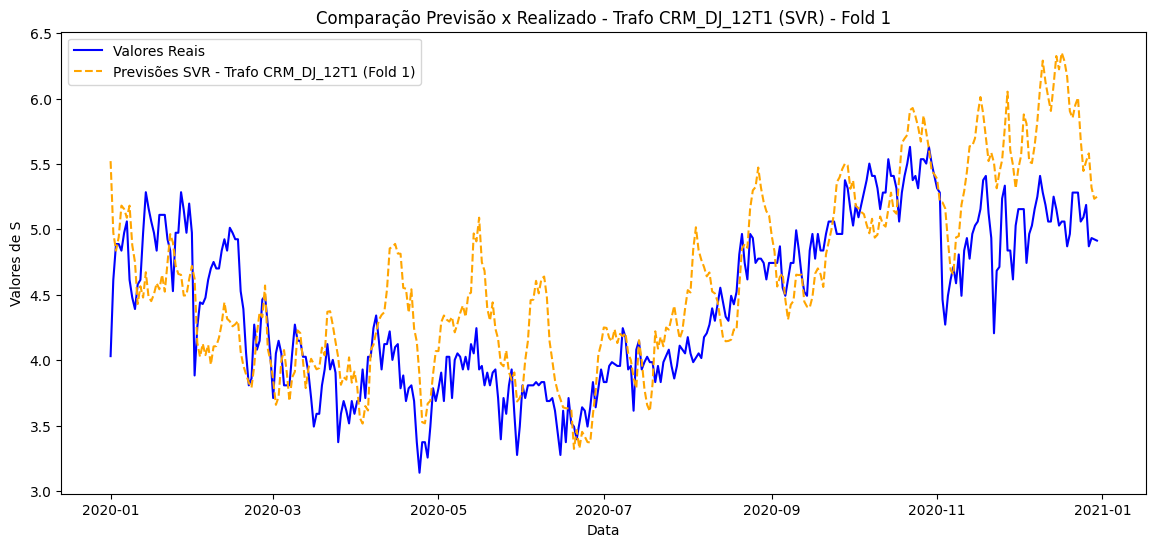

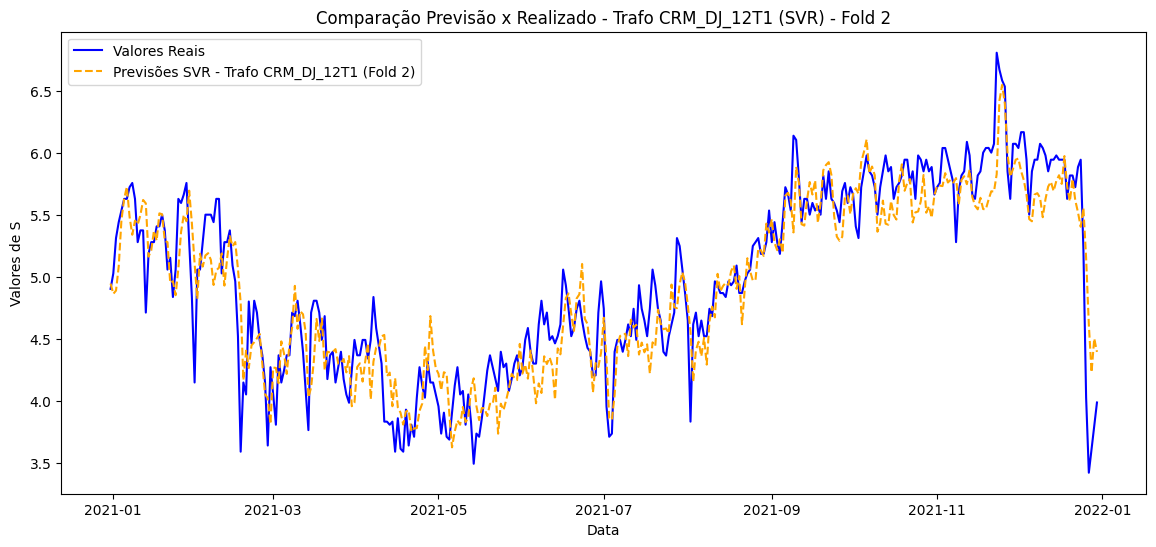

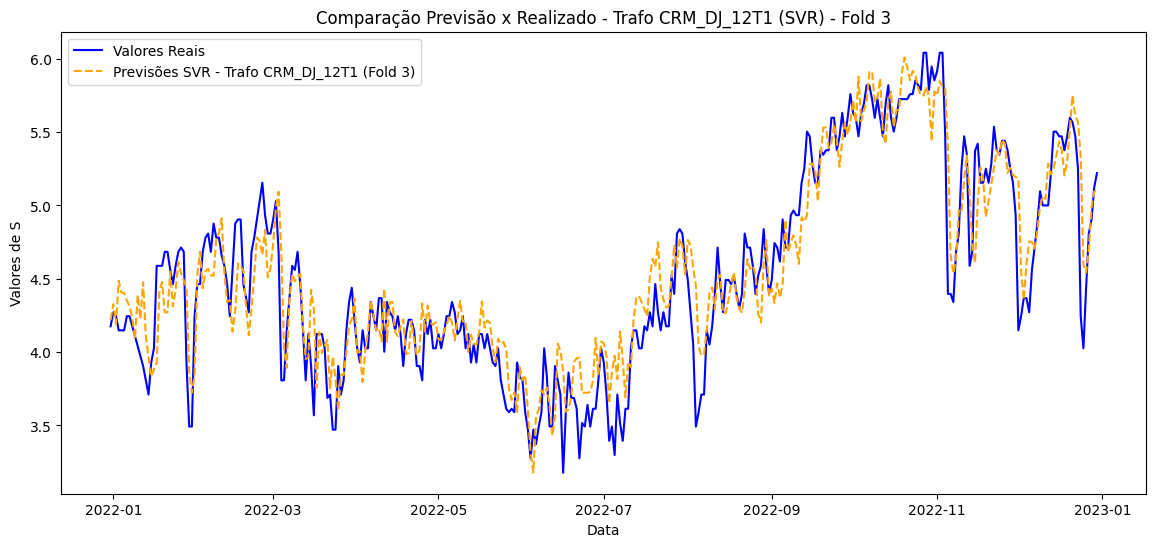

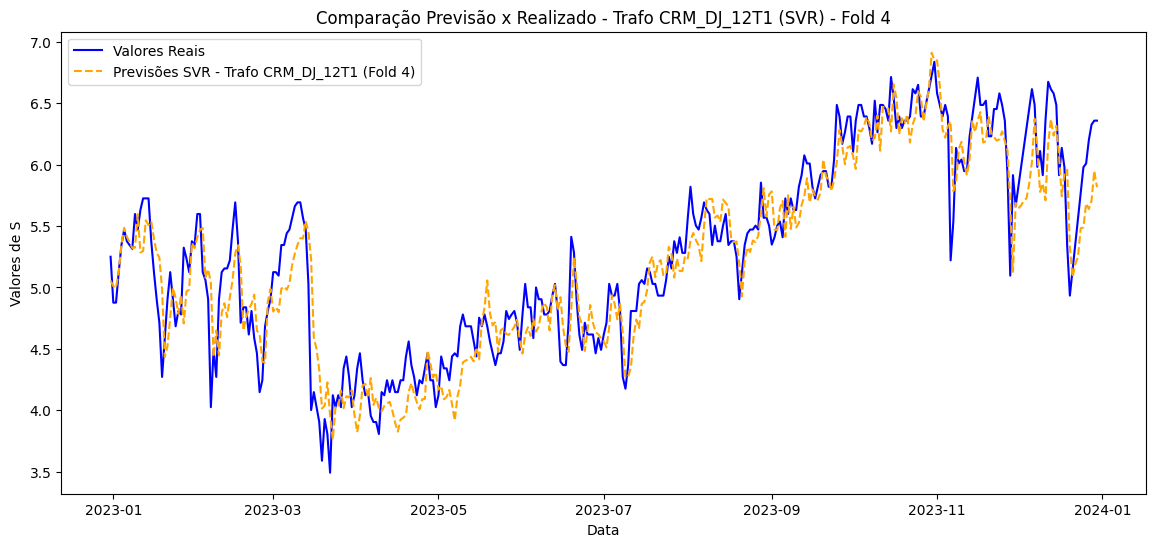

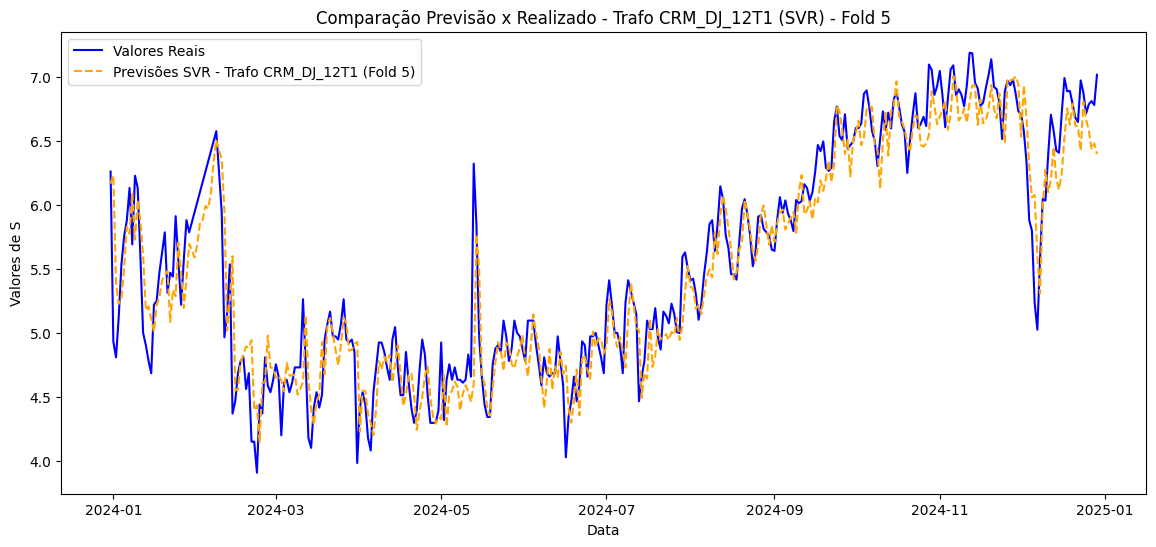

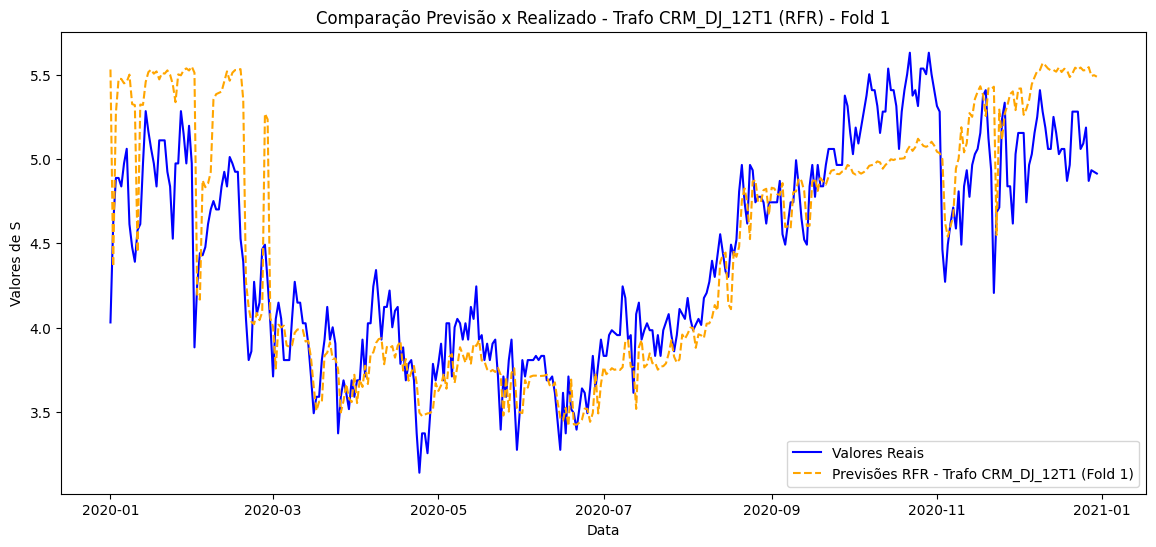

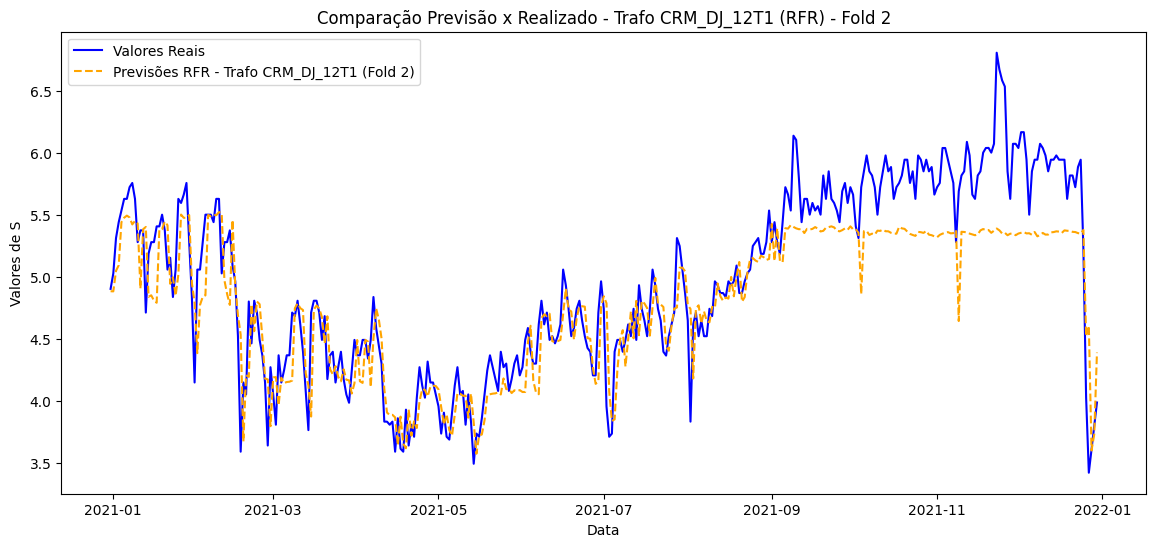

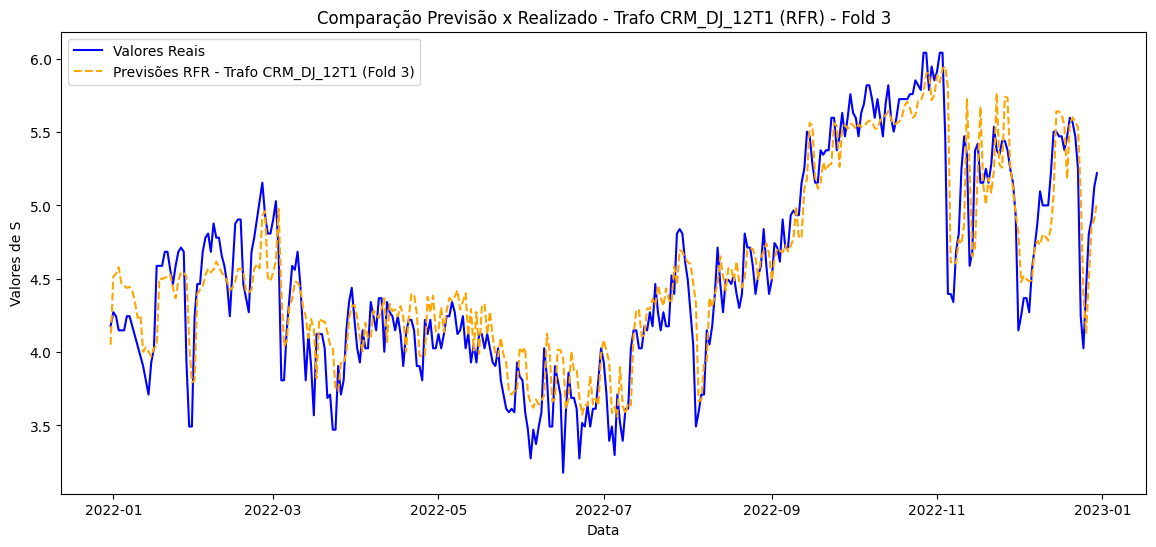

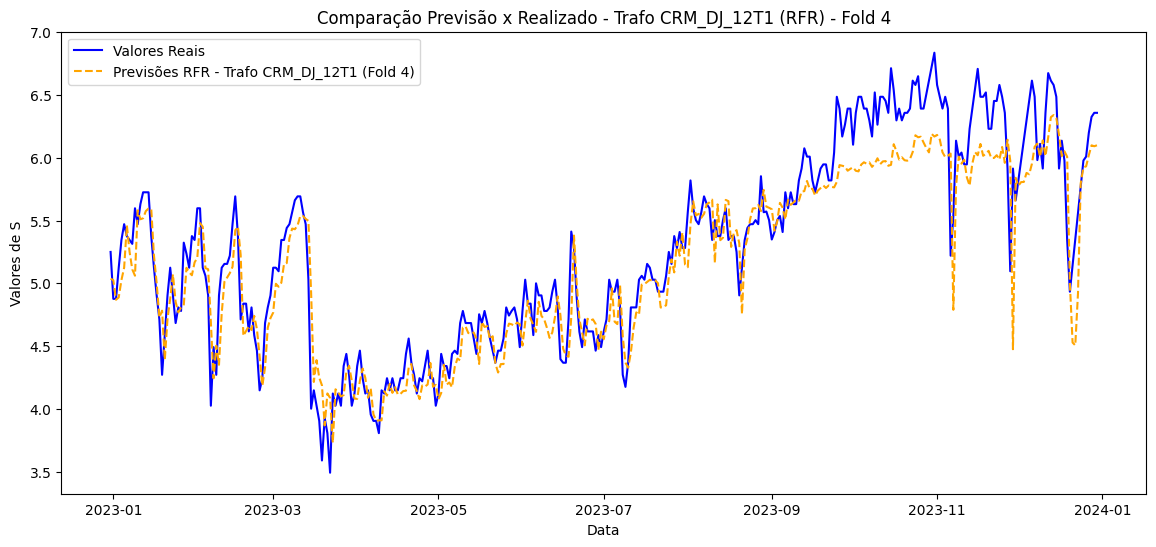

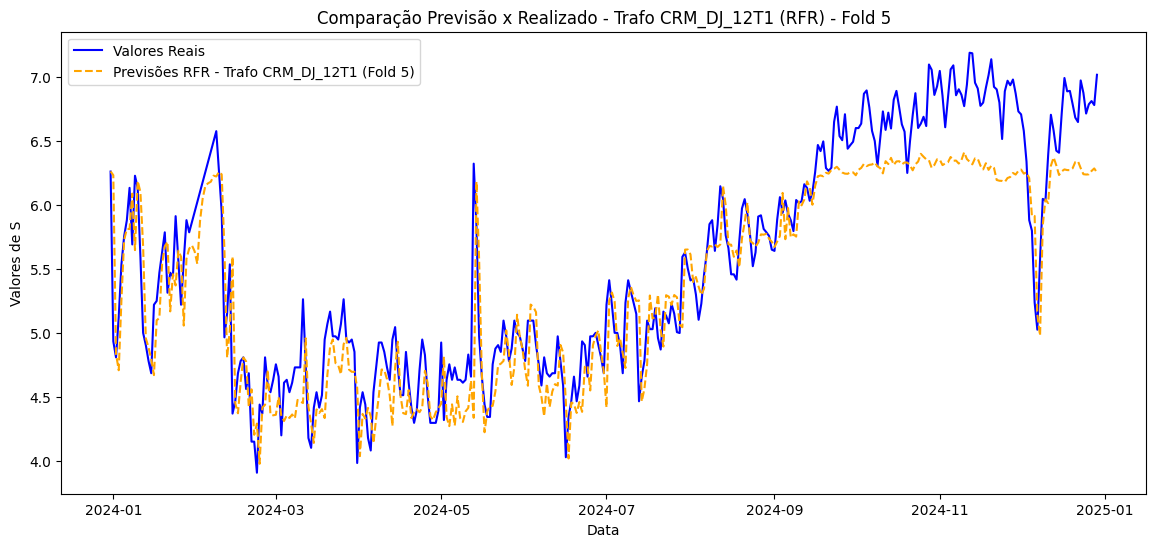

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


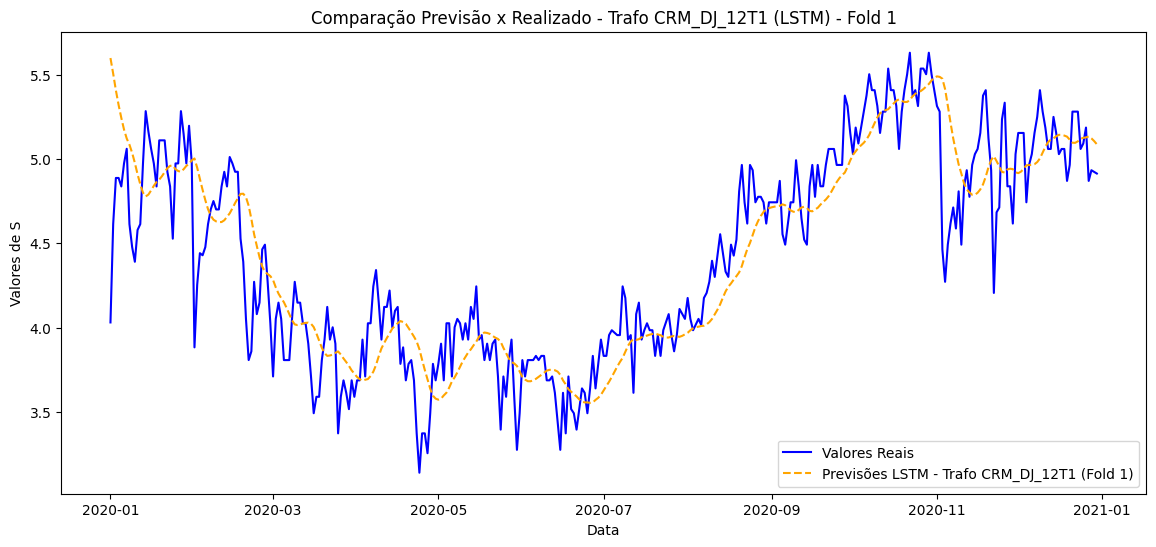

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


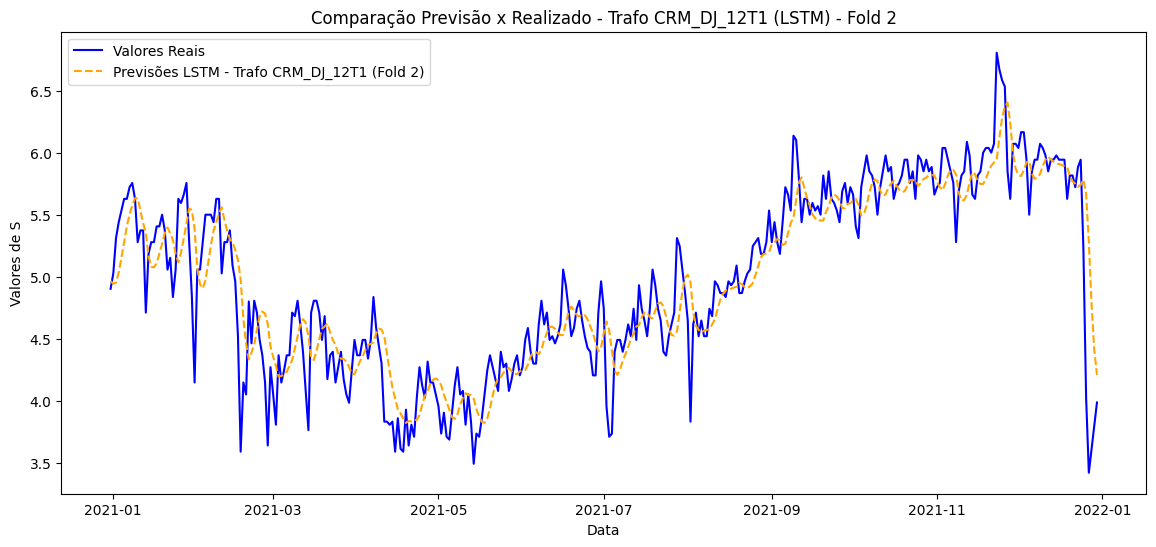

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


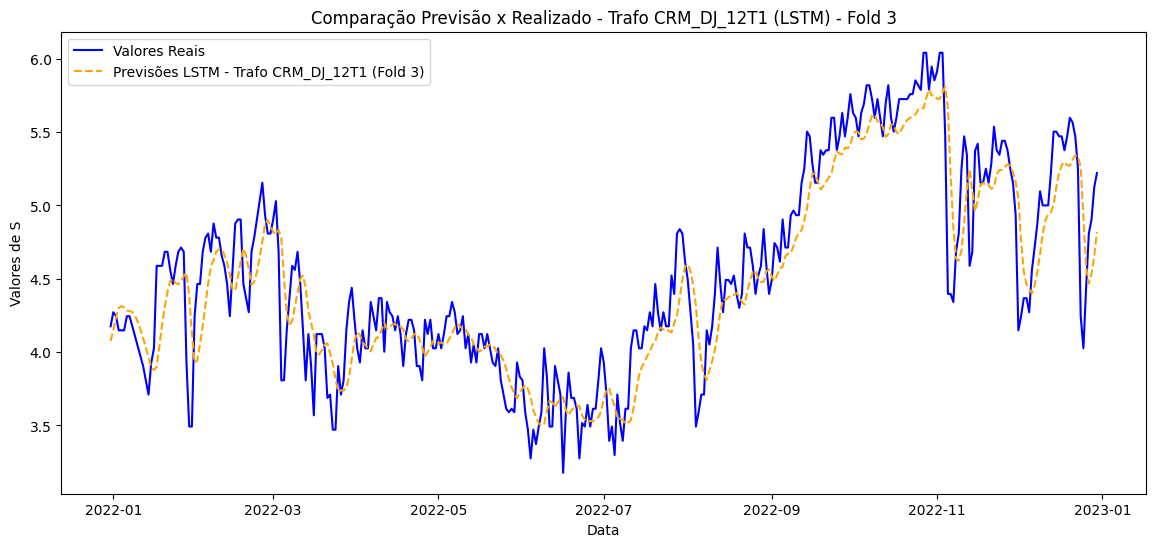

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


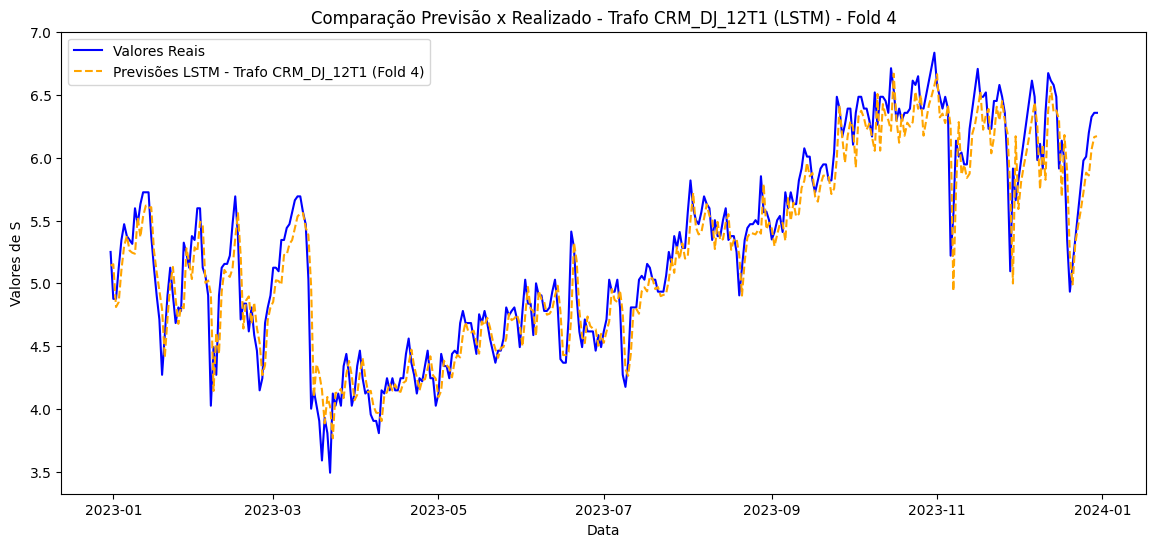

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


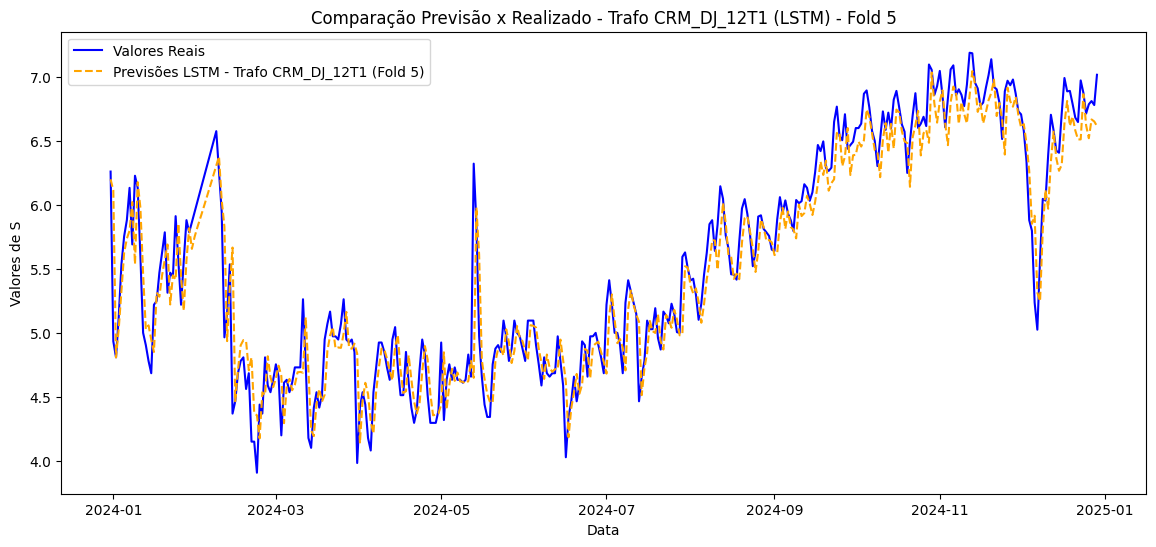

Resultados SVR:
         Trafo Modelo  Fold  RMSE  MAE   R2
0  CRM_DJ_12T1    SVR     1  0.48 0.39 0.39
1  CRM_DJ_12T1    SVR     2  0.31 0.24 0.83
2  CRM_DJ_12T1    SVR     3  0.27 0.20 0.85
3  CRM_DJ_12T1    SVR     4  0.28 0.22 0.87
4  CRM_DJ_12T1    SVR     5  0.29 0.21 0.89

Resultados RFR:
         Trafo Modelo  Fold  RMSE  MAE   R2
0  CRM_DJ_12T1    RFR     1  0.35 0.27 0.67
1  CRM_DJ_12T1    RFR     2  0.38 0.29 0.74
2  CRM_DJ_12T1    RFR     3  0.25 0.20 0.86
3  CRM_DJ_12T1    RFR     4  0.30 0.23 0.85
4  CRM_DJ_12T1    RFR     5  0.37 0.29 0.82

Resultados LSTM:
         Trafo Modelo  Fold  RMSE  MAE   R2
0  CRM_DJ_12T1   LSTM     1  0.29 0.21 0.78
1  CRM_DJ_12T1   LSTM     2  0.33 0.23 0.81
2  CRM_DJ_12T1   LSTM     3  0.29 0.22 0.82
3  CRM_DJ_12T1   LSTM     4  0.24 0.18 0.91
4  CRM_DJ_12T1   LSTM     5  0.27 0.19 0.91


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import random

# Fixando seeds para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

def plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo, fold):
    plt.figure(figsize=(14, 6))
    plt.plot(df_previsoes, y_test_inverso, label='Valores Reais', color='blue')
    plt.plot(df_previsoes, y_pred, label=f'Previsões {modelo} - Trafo {trafo} (Fold {fold})', linestyle='--', color='orange')
    plt.xlabel('Data')
    plt.ylabel('Valores de S')
    plt.title(f'Comparação Previsão x Realizado - Trafo {trafo} ({modelo}) - Fold {fold}')
    plt.legend()
    plt.show()

def walk_forward_validation(df_filtrado, trafos_escolhidos, modelo, janela, epochs=20, batch_size=32):
    resultados = []

    for trafo in trafos_escolhidos:
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S']]
        df = df.set_index(['datahora']).resample('D').max()
        df.sort_index(inplace=True)
        df['S'] = df['S'].interpolate(method='linear')

        dados = df[['S']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler.fit_transform(dados)

        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, 0])
            y.append(dados_normalizados[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1)) if modelo == 'LSTM' else X

        n_splits = 5  # Número de folds para validação walk-forward
        split_size = len(X) // (n_splits + 1)

        for fold in range(n_splits):
            train_size = split_size * (fold + 1)
            X_train, X_test = X[:train_size], X[train_size:train_size + split_size]
            y_train, y_test = y[:train_size], y[train_size:train_size + split_size]

            if modelo == 'SVR':
                regressor = SVR(kernel='rbf', C=100, gamma=0.001, epsilon=0.01)
            elif modelo == 'RFR':
                regressor = RandomForestRegressor(n_estimators=250, random_state=42)
            elif modelo == 'LSTM':
                regressor = Sequential()
                regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
                regressor.add(LSTM(units=50))
                regressor.add(Dense(1))
                regressor.compile(optimizer='adam', loss='mean_squared_error')
                regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            regressor.fit(X_train, y_train) if modelo != 'LSTM' else None
            y_pred_normalizado = regressor.predict(X_test)
            y_pred = scaler.inverse_transform(y_pred_normalizado.reshape(-1, 1))
            y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

            mse = mean_squared_error(y_test_inverso, y_pred)
            rmse = sqrt(mse)
            mae = mean_absolute_error(y_test_inverso, y_pred)
            r2 = r2_score(y_test_inverso, y_pred)

            df_previsoes = df.index[train_size + janela:train_size + janela + split_size]
            plotar_resultados(df_previsoes, y_test_inverso, y_pred, trafo, modelo, fold + 1)

            resultados.append({
                'Trafo': trafo,
                'Modelo': modelo,
                'Fold': fold + 1,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

    return pd.DataFrame(resultados)

# Chamando para SVR, RFR e LSTM
resultados_svr = walk_forward_validation(df_filtrado, trafos_escolhidos, modelo='SVR', janela=365)
resultados_rfr = walk_forward_validation(df_filtrado, trafos_escolhidos, modelo='RFR', janela=365)
resultados_lstm = walk_forward_validation(df_filtrado, trafos_escolhidos, modelo='LSTM', janela=365, epochs=20, batch_size=32)

print("Resultados SVR:")
print(resultados_svr)
print("\nResultados RFR:")
print(resultados_rfr)
print("\nResultados LSTM:")
print(resultados_lstm)
